## LDA Model Visualization and Subject Analysis

In [144]:
#import necessary packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import re
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import necessary packages for further word processing
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2020)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /global/homes/d/dsmorrow/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#function to perform lemmatize and stem preprocessing steps on the data set.
def lemmatize_stemming(text):
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(lemmatize_stemming(token))
    return result

In [159]:
#load in csv with pre=preprocessing already done on the text (lowercasing, etc.)
full_proc = pd.read_csv("Full_Table_ICD9_Notes.csv", usecols=['SUBJECT_ID',"CATEGORY",'text_processed'])
full_proc

,SUBJECT_ID,CATEGORY,text_processed
0,109,Discharge summary,admission date 2142 5 15 discharge date 2142 5...
1,109,Discharge summary,admission date 2142 5 20 discharge date 2142 6...
2,109,Discharge summary,admission date 2142 6 18 discharge date 2142 6...
3,109,Discharge summary,admission date 2142 7 3 discharge date 2142 7 ...
4,109,Discharge summary,admission date 2142 7 7 discharge date 2142 7 ...
...,...,...,...
323055,65504,Radiology,last name lf first name3 lf 1046 j last name ...
323056,65504,Radiology,2143 9 3 9 59 am chest pa lat clip clip numbe...
323057,65504,Radiology,2144 2 25 1 49 pm ankle ap mortise lat left c...
323058,65504,Radiology,2144 1 7 4 21 pm ankle ap mortise lat left cl...


Selecting a subject ID from the 'full_proc' dataframe allows us to see how the LDA model can identify topics within certain documents.
Specifically, if we look at the potential topics for a subject, we can infer whether or not they are at higher risk of suicide
Lets see how well this LDA Model worked when we look at a subject within the training group

In [160]:
#select only for subject 109 from the DoD group
subject_1 = full_proc.loc[full_proc['SUBJECT_ID'] == 109]

In [163]:
subject_109 = subject_1.drop_duplicates()

In [164]:
#complete preprocesseding on text to stem and lemmatize
subject_109_docs = subject_109['text_processed'].map(preprocess)

In [165]:
subject_109_docs

0       [admiss, date, discharg, date, date, birth, se...
1       [admiss, date, discharg, date, date, birth, se...
2       [admiss, date, discharg, date, date, birth, se...
3       [admiss, date, discharg, date, date, birth, se...
4       [admiss, date, discharg, date, date, birth, se...
                              ...                        
1212    [chief, complaint, hour, event, sbp, overnight...
1213    [chief, complaint, hour, event, dialysi, cathe...
1214    [chief, complaint, saw, examin, patient, physi...
1215    [chief, complaint, saw, examin, patient, physi...
1216    [titl, chief, complaint, new, onset, seizur, h...
Name: text_processed, Length: 1214, dtype: object

In [166]:
#create dictionary of words
dictionary_109 = gensim.corpora.Dictionary(subject_109_docs)
count = 0
for k, v in dictionary_109.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abdomen
1 abdomin
2 abl
3 abnorm
4 abus
5 accid
6 acut
7 admiss
8 admit
9 afebril
10 age


In [167]:
#filter out words that appear in less than (8) documents
#only keep the first 10000
dictionary_109.filter_extremes(no_below=8, no_above=0.5, keep_n=100000)

In [168]:
#convert dictionary to BOW for LDA model to process
bow_corpus_109 = [dictionary_109.doc2bow(doc) for doc in subject_109_docs]

In [169]:
#determine the TF-IDF scores or weight of a word within a document
from gensim import corpora, models
tfidf_109 = models.TfidfModel(bow_corpus_109)
corpus_tfidf_109 = tfidf_109[bow_corpus_109]

In [ ]:
#process full text for all subject for visualization 

In [170]:
#change variable for LDA modeling
documents = full_proc.drop_duplicates()

In [171]:
#use preprocess function on all notes and subjects
processed_docs = documents['text_processed'].map(preprocess)

In [172]:
#create dictionary of words and number of appearances 
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abdomen
1 abdomin
2 abl
3 abnorm
4 abus
5 accid
6 acut
7 admiss
8 admit
9 afebril
10 age


In [173]:
#filter out words that appear in less than (15) documents
#only keep the first 10000
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [174]:
#go through each document and report words and occurrences using doc2box for token id and amount
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [175]:
#determine the TF-IDF scores or weight of a word within the documents
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [176]:
#train LDA model using BOW, chunk size is 5000 documents, lda is updated after every chunk size, 2 full passes through the corpus for training, produce 10 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5000,
                                           passes=2)

In [234]:
# Print the Keywords in the 20 topics using the BOW corpus
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

[(0,
  '0.019*"continu" + 0.019*"hct" + 0.018*"bleed" + 0.013*"blood" + '
  '0.013*"renal" + 0.011*"give" + 0.011*"cultur" + 0.010*"hypotens" + '
  '0.009*"like" + 0.008*"unit"'),
 (1,
  '0.016*"continu" + 0.011*"give" + 0.010*"patient" + 0.009*"home" + '
  '0.009*"like" + 0.008*"heart" + 0.007*"respiratori" + 0.007*"lasix" + '
  '0.007*"improv" + 0.006*"copd"'),
 (2,
  '0.023*"head" + 0.021*"contrast" + 0.021*"hemorrhag" + 0.017*"leav" + '
  '0.017*"right" + 0.012*"clip" + 0.011*"reason" + 0.010*"mass" + 0.010*"acut" '
  '+ 0.009*"brain"'),
 (3,
  '0.013*"date" + 0.013*"arteri" + 0.013*"meq" + 0.012*"patient" + '
  '0.010*"order" + 0.009*"tube" + 0.009*"nutrit" + 0.008*"current" + '
  '0.008*"weight" + 0.007*"surgeri"'),
 (4,
  '0.037*"fractur" + 0.025*"spine" + 0.017*"right" + 0.016*"leav" + '
  '0.013*"clip" + 0.013*"reason" + 0.011*"hip" + 0.011*"spinal" + 0.010*"pain" '
  '+ 0.009*"cervic"'),
 (5,
  '0.009*"remain" + 0.009*"continu" + 0.008*"note" + 0.008*"vent" + '
  '0.008*"pain

In [259]:
#train LDA model using TFIDF corpus, chunk size is 5000 documents, lda is updated after every chunk size, 2 full passes through the corpus for training, produce 10 topics
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5000,
                                           passes=2)

In [260]:
# Print the Keywords in the 20 topics using the BOW corpus
pprint(lda_model2.print_topics())
doc_lda_tf = lda_model2[corpus_tfidf]

[(0,
  '0.016*"contrast" + 0.015*"hemorrhag" + 0.012*"head" + 0.010*"intracrani" + '
  '0.009*"vein" + 0.009*"clip" + 0.008*"mass" + 0.008*"frontal" + '
  '0.008*"brain" + 0.008*"reason"'),
 (1,
  '0.032*"fo" + 0.028*"obstip" + 0.023*"tracer" + 0.019*"exhal" + 0.018*"pin" '
  '+ 0.016*"mci" + 0.016*"namepattern" + 0.015*"vac" + 0.013*"exercis" + '
  '0.013*"disciti"'),
 (2,
  '0.018*"valuabl" + 0.012*"sdh" + 0.012*"transfer" + 0.012*"money" + '
  '0.012*"wallet" + 0.009*"meq" + 0.008*"home" + 0.007*"pmh" + 0.006*"cloth" + '
  '0.006*"namepattern"'),
 (3,
  '0.022*"aaa" + 0.015*"saphen" + 0.014*"echogen" + 0.014*"perfor" + '
  '0.014*"graft" + 0.013*"bypass" + 0.012*"neutropenia" + 0.012*"anastomosi" + '
  '0.012*"neutropen" + 0.012*"gallston"'),
 (4,
  '0.047*"valv" + 0.028*"aortic" + 0.027*"mitral" + 0.025*"leaflet" + '
  '0.021*"normal" + 0.017*"ventricular" + 0.016*"doppler" + 0.015*"mildli" + '
  '0.015*"wall" + 0.015*"systol"'),
 (5,
  '0.035*"sound" + 0.031*"ventil" + 0.026*"cuff

In [180]:
#create function to create end up with dataframe that includes, the document index, the dominant topic for that document based on the trained LDA model, The percentage of matching, the top weighted words for that topic, and the text of the document
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_109, texts=subject_109_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.4991,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
1,1,18.0,0.3900,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
2,2,18.0,0.4829,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
3,3,18.0,0.4544,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
4,4,18.0,0.3968,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
5,5,18.0,0.4049,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
6,6,18.0,0.4750,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
7,7,18.0,0.4586,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
8,8,18.0,0.3444,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
9,9,18.0,0.3663,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."


In [183]:
#subject 109 of DoD has a dominant topic from almost all potential topics

In [184]:
#create funcs and visualization for word count and weight of top words for each topic
from collections import Counter
topics = lda_model.show_topics(formatted=False, num_topics=20)
data_flat = [w for w_list in processed_docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

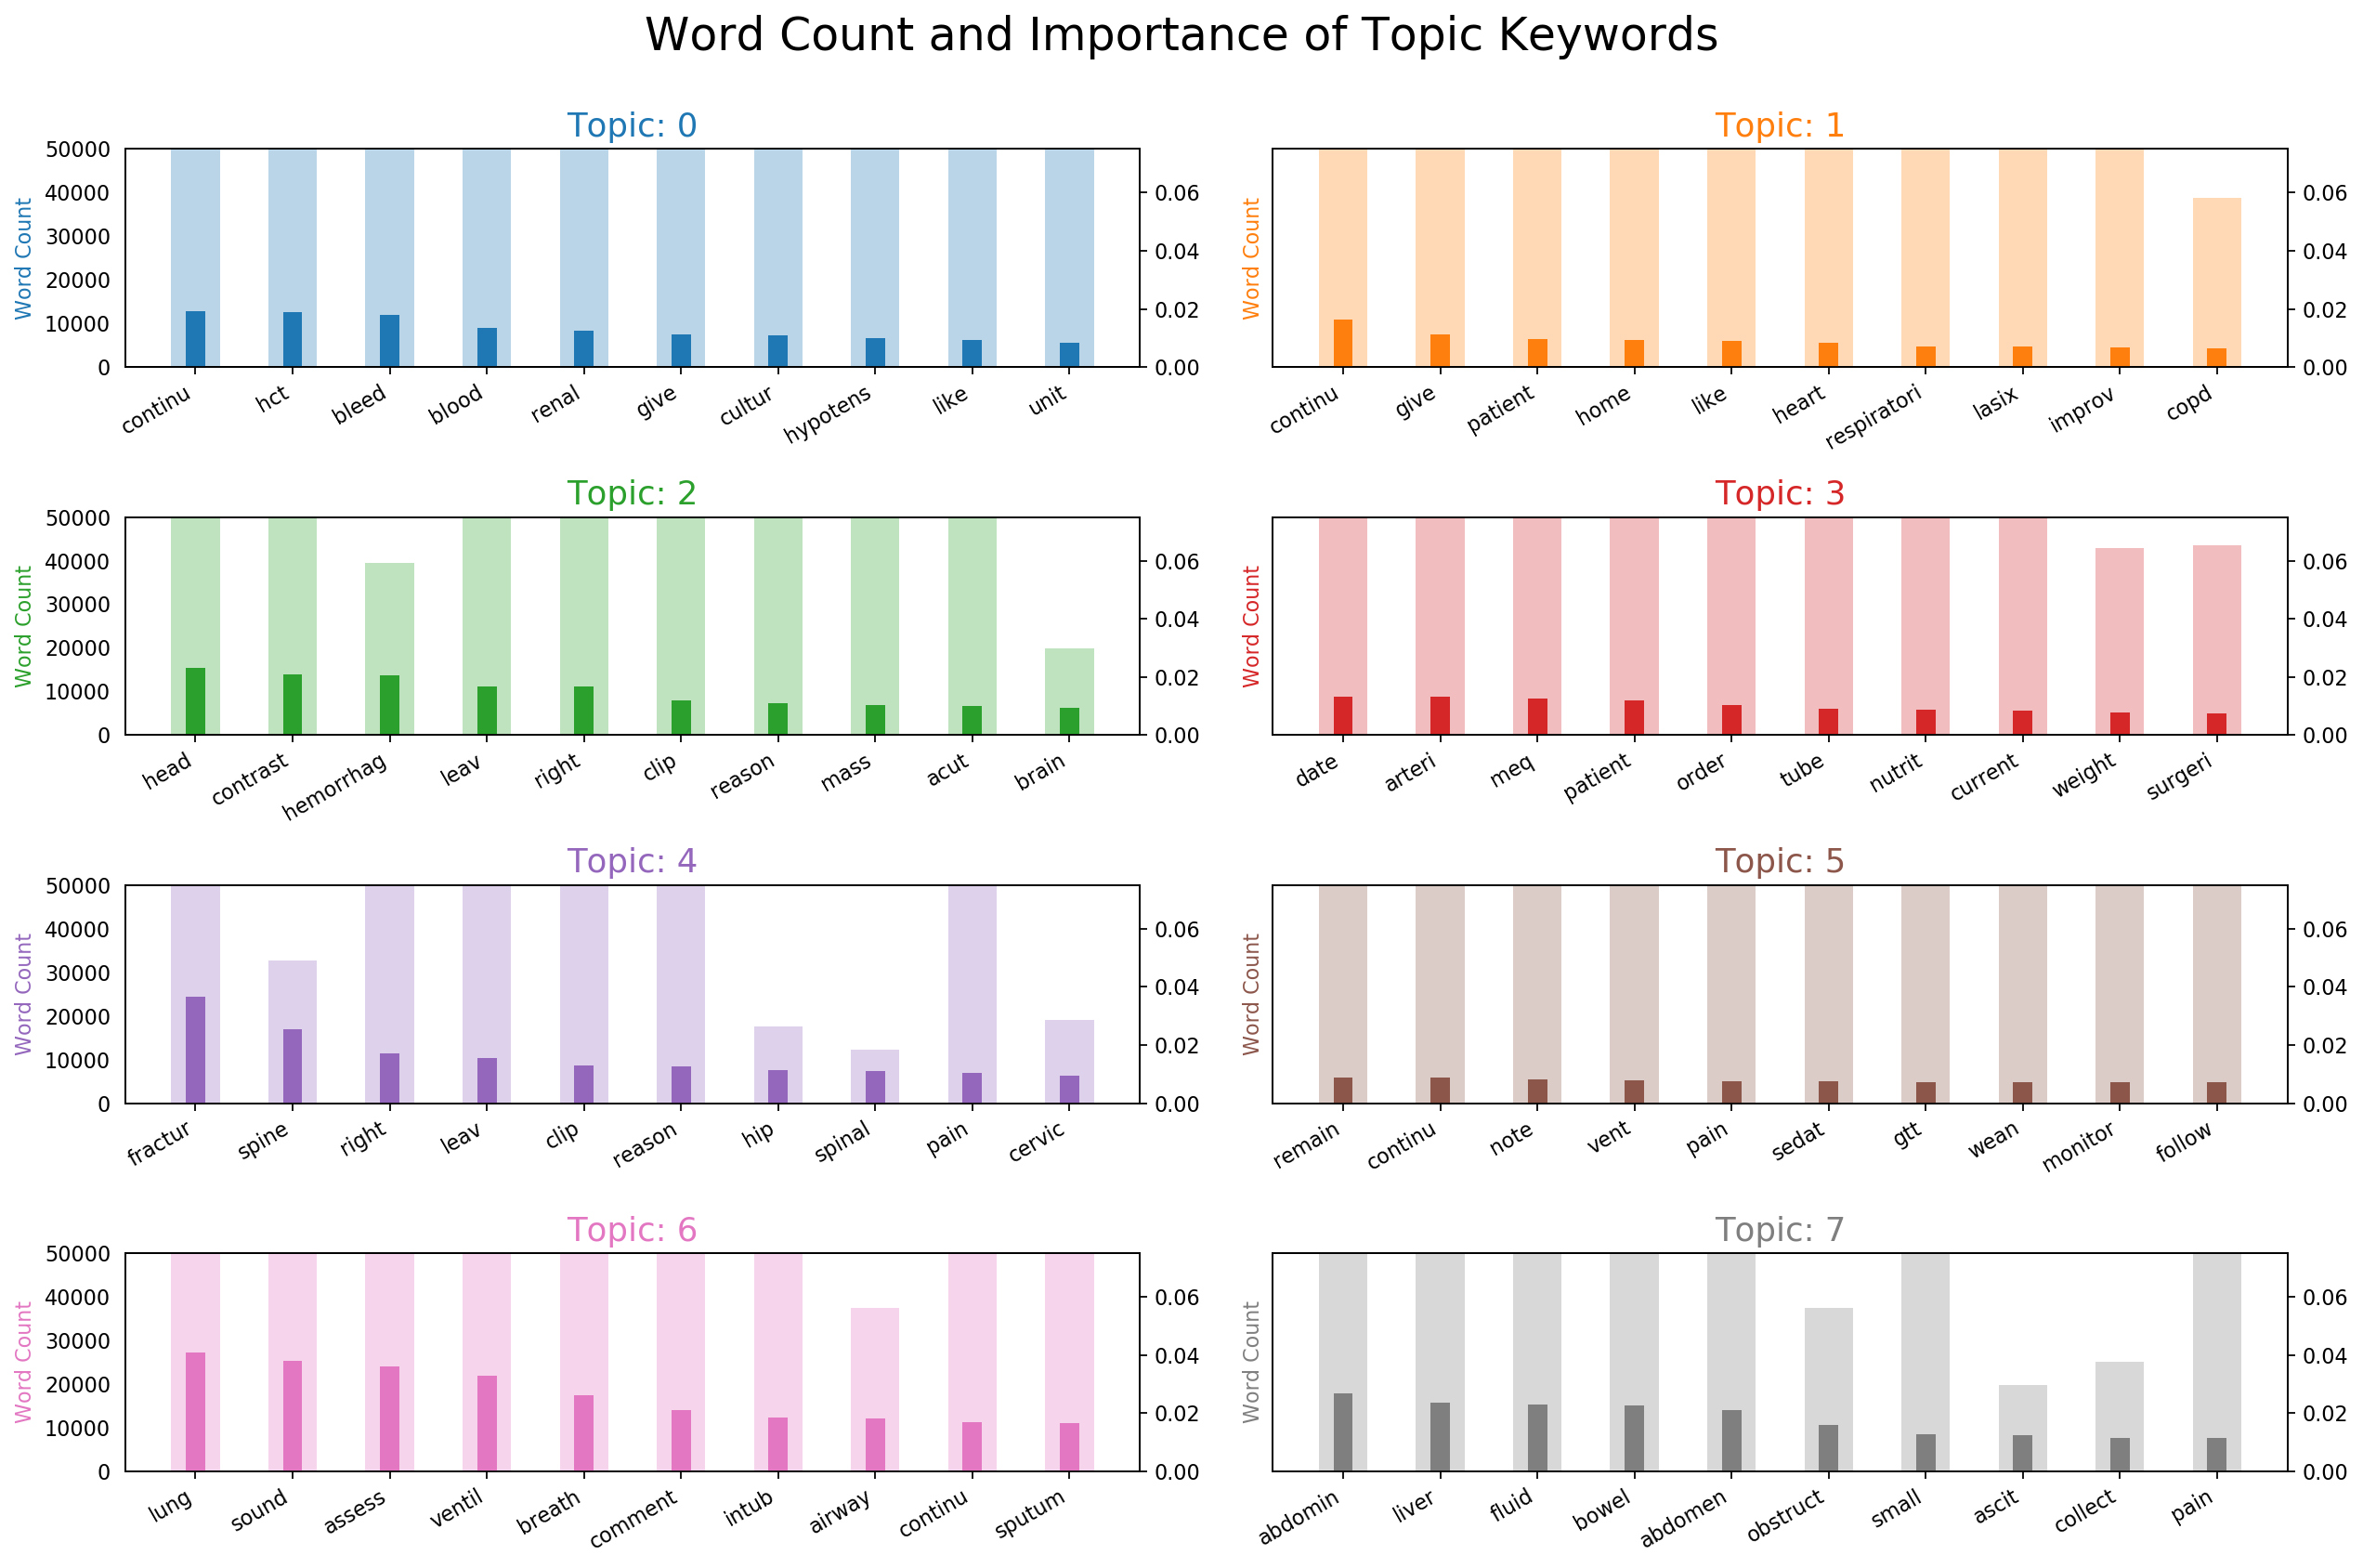

In [185]:
# Plot Word Count and Weights of Topic Keywords by topics from LDA model
fig, axes = plt.subplots(4, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.075); ax.set_ylim(0, 50000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

This visualization looks at each topic configured from the LDA training, and plots the top weighted words along with their word frequency

In [186]:
#sorted and appending topics and percentages of the LDA topics
def topics_per_document(model, corpus):
    corpus_sel = corpus[0:-1]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

#looking at just subject 109 from DoD; preprocessing done at the beginning of the notebook
dominant_topics, topic_percentages = topics_per_document(lda_model, bow_corpus_109)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

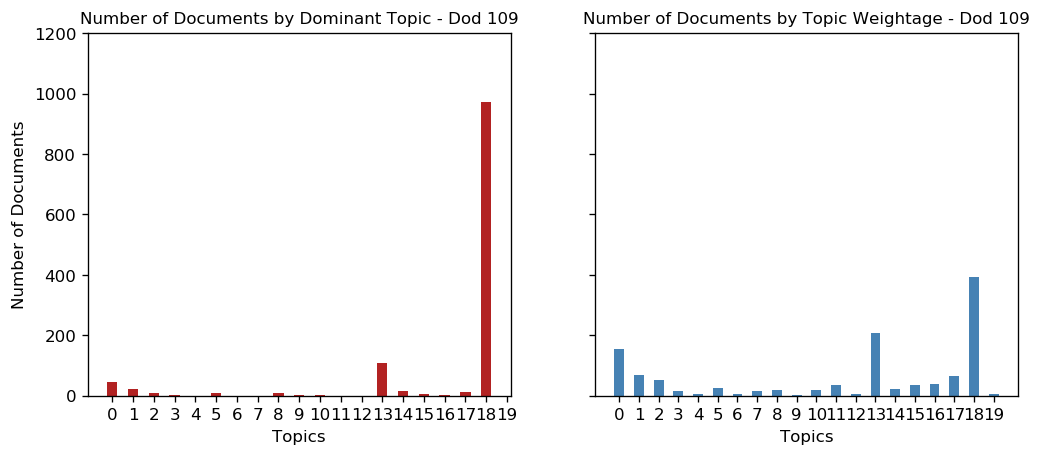

In [187]:
#topic weightage is the sum of all documents that have a weight for that topic

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('Number of Documents by Dominant Topic - Dod 109', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1200)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.set_title('Number of Documents by Topic Weightage - Dod 109', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

Back to subject 109:
Based on this subjects documents, they have a probability of falling under almost of the LDA topics
Topic 18 is where the majority of documents have a probability of falling under

In [189]:
#reread in csv so that i can select for only suicide attempt subjects instead of DoD
dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in dates]
diagnosis_icd9 = pd.read_csv("/project/projectdirs/m1532/Projects_MVP/_datasets/mimiciii/DIAGNOSES_ICD.csv", usecols= ["SUBJECT_ID", "ICD9_CODE"])
patients = pd.read_csv("/project/projectdirs/m1532/Projects_MVP/_datasets/mimiciii/PATIENTS.csv", parse_dates= ["DOB"], date_parser=dateparse, usecols=["SUBJECT_ID", "DOB"])
admissions = pd.read_csv("/project/projectdirs/m1532/Projects_MVP/_datasets/mimiciii/ADMISSIONS.csv", parse_dates= ["ADMITTIME"], date_parser=dateparse, usecols=["SUBJECT_ID", "ADMITTIME"])
notes = pd.read_csv("/project/projectdirs/m1532/Projects_MVP/_datasets/mimiciii/NOTEEVENTS.csv", usecols = ['SUBJECT_ID','CATEGORY', 'TEXT'])

In [190]:
#filter for only suicide attempts ICD9 codes
diag_suicide_DF = diagnosis_icd9[diagnosis_icd9["ICD9_CODE"].str.startswith(('E95'), na = False)]
diag_suicide_DF.head()

,SUBJECT_ID,ICD9_CODE
102,119,E956
350,71,E9503
760,22,E9502
761,22,E9503
2036,303,E9500


In [191]:
#merge suicide dataframe with notes
icd9_suicide = pd.merge(diag_suicide_DF, notes, on ='SUBJECT_ID')
icd9_suicide

,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT
0,119,E956,ECG,Sinus rhythm\nHigh QRS voltage - probable norm...
1,119,E956,ECG,"Normal sinus rhythm, rate 94\nNonspecific ante..."
2,119,E956,Radiology,[**2159-9-12**] 6:44 AM\n WRIST(3 + VIEWS) LEF...
3,119,E956,Radiology,[**2159-9-12**] 6:46 AM\n CHEST (PRE-OP AP ONL...
4,119,E956,Nursing/other,"awake,alert, and oriented x3. pt is calm and c..."
...,...,...,...,...
23020,97625,E9500,Radiology,[**2105-2-17**] 7:17 AM\n CHEST (PORTABLE AP) ...
23021,97625,E9500,Radiology,[**2105-2-16**] 12:08 AM\n CHEST (PORTABLE AP)...
23022,97625,E9500,Physician,TITLE:\n Chief Complaint: acute hepatic inj...
23023,97625,E9500,Physician,TITLE:\n Chief Complaint: acute hepatic inj...


In [192]:
#bring in the admittime column from separate csv
icd9_suicide = pd.merge(icd9_suicide, admissions, on="SUBJECT_ID")
icd9_suicide.head()

,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT,ADMITTIME
0,119,E956,ECG,Sinus rhythm\nHigh QRS voltage - probable norm...,2159-09-12 15:26:00
1,119,E956,ECG,"Normal sinus rhythm, rate 94\nNonspecific ante...",2159-09-12 15:26:00
2,119,E956,Radiology,[**2159-9-12**] 6:44 AM\n WRIST(3 + VIEWS) LEF...,2159-09-12 15:26:00
3,119,E956,Radiology,[**2159-9-12**] 6:46 AM\n CHEST (PRE-OP AP ONL...,2159-09-12 15:26:00
4,119,E956,Nursing/other,"awake,alert, and oriented x3. pt is calm and c...",2159-09-12 15:26:00


In [193]:
#pre-preprocess these notes
# Remove punctuation and anything that isnt a character or number 
icd9_suicide['text_processed'] = icd9_suicide['TEXT'].map(lambda x: re.sub('[_\\W]+', ' ', x))
# Convert to lowercase
icd9_suicide['text_processed'] = icd9_suicide['text_processed'].map(lambda x: x.lower())
icd9_suicide

,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT,ADMITTIME,text_processed
0,119,E956,ECG,Sinus rhythm\nHigh QRS voltage - probable norm...,2159-09-12 15:26:00,sinus rhythm high qrs voltage probable normal ...
1,119,E956,ECG,"Normal sinus rhythm, rate 94\nNonspecific ante...",2159-09-12 15:26:00,normal sinus rhythm rate 94 nonspecific antero...
2,119,E956,Radiology,[**2159-9-12**] 6:44 AM\n WRIST(3 + VIEWS) LEF...,2159-09-12 15:26:00,2159 9 12 6 44 am wrist 3 views left port cli...
3,119,E956,Radiology,[**2159-9-12**] 6:46 AM\n CHEST (PRE-OP AP ONL...,2159-09-12 15:26:00,2159 9 12 6 46 am chest pre op ap only port c...
4,119,E956,Nursing/other,"awake,alert, and oriented x3. pt is calm and c...",2159-09-12 15:26:00,awake alert and oriented x3 pt is calm and coo...
...,...,...,...,...,...,...
42548,97625,E9500,Radiology,[**2105-2-17**] 7:17 AM\n CHEST (PORTABLE AP) ...,2105-02-15 18:00:00,2105 2 17 7 17 am chest portable ap clip clip...
42549,97625,E9500,Radiology,[**2105-2-16**] 12:08 AM\n CHEST (PORTABLE AP)...,2105-02-15 18:00:00,2105 2 16 12 08 am chest portable ap clip cli...
42550,97625,E9500,Physician,TITLE:\n Chief Complaint: acute hepatic inj...,2105-02-15 18:00:00,title chief complaint acute hepatic injury hpi...
42551,97625,E9500,Physician,TITLE:\n Chief Complaint: acute hepatic inj...,2105-02-15 18:00:00,title chief complaint acute hepatic injury hpi...


In [194]:
#adding additional index column for calling
index = tuple(range(0, 42553, 1))
icd9_suicide["index"] = index

In [195]:
#select only for subject 303 that has attempted suicide
documents_suicide = icd9_suicide.loc[icd9_suicide['SUBJECT_ID'] == 303]

In [196]:
#resetting index because following code for dataframe has trouble identifying text when pulling from middle of dataframe
documents_suicide = documents_suicide.reset_index()

In [197]:
#use preprocess function on suicide attempt subjects
processed_docs_suicide = documents_suicide['text_processed'].map(preprocess)

In [198]:
#create dictionary of words
dictionary_303s = gensim.corpora.Dictionary(processed_docs_suicide)
count = 0
for k, v in dictionary_303s.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abdomen
1 accid
2 admiss
3 admit
4 allergi
5 ambul
6 birth
7 blood
8 brace
9 brief
10 bring


In [199]:
#filter out words that appear in less than (5) documents - adjusted due to the sig smaller amount of documents for this subject
#only keep the first 10000
dictionary_303s.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

In [200]:
#go through each document and report words and occurrences using doc2box for token id and amount
bow_corpus_303s = [dictionary_303s.doc2bow(doc) for doc in processed_docs_suicide]

In [201]:
#sorted and appending topics and percentages of the LDA topics (function can be found above)
dominant_topics_303, topic_percentages_303 = topics_per_document(lda_model, bow_corpus_303s)            

# Distribution of Dominant Topics in Each Document
df_303 = pd.DataFrame(dominant_topics_303, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_303 = df_303.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_303 = dominant_topic_in_each_doc_303.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_303 = pd.DataFrame([dict(t) for t in topic_percentages_303])
df_topic_weightage_by_doc_303 = topic_weightage_by_doc_303.sum().to_frame(name='count').reset_index()

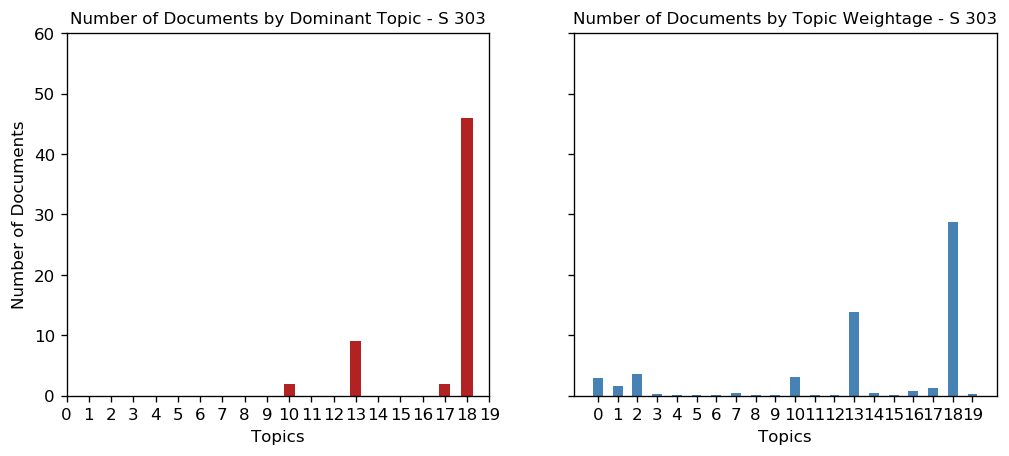

In [202]:
# Plot for subject 303 comparing document topics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_303, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('Number of Documents by Dominant Topic - S 303', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 60)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_303, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc_303.index.unique().__len__()))
ax2.set_title('Number of Documents by Topic Weightage - S 303', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

Suicide attempt subject 303 only has 4 dominant topics that their documents fall under.

In [203]:
#function found above
df_topic_sents_keywords_303 = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_303s, texts=processed_docs_suicide)

# Format
df_dominant_topic_303 = df_topic_sents_keywords_303.reset_index()
df_dominant_topic_303.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_303.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.4755,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
1,1,18.0,0.4766,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
2,2,18.0,0.3976,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
3,3,18.0,0.3976,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
4,4,10.0,0.6833,"procedur, picc, cathet, identifi, line, numer,...","[sinu, rhythm, normal, ecg, age]"
5,5,10.0,0.6833,"procedur, picc, cathet, identifi, line, numer,...","[sinu, rhythm, normal, ecg, age]"
6,6,18.0,0.7506,"tablet, daili, blood, day, sig, discharg, hosp...","[sinu, rhythm, slight, non, specif, inferior, ..."
7,7,18.0,0.7506,"tablet, daili, blood, day, sig, discharg, hosp...","[sinu, rhythm, slight, non, specif, inferior, ..."
8,8,18.0,0.5269,"tablet, daili, blood, day, sig, discharg, hosp...","[trauma, seri, lat, spine, cxr, pelvi, port, c..."
9,9,18.0,0.5268,"tablet, daili, blood, day, sig, discharg, hosp...","[trauma, seri, lat, spine, cxr, pelvi, port, c..."


In [204]:
#how many documents for each dominant topic
df_dominant_topic_303.groupby('Dominant_Topic').size()

Dominant_Topic
10.0     2
13.0    10
17.0     2
18.0    46
dtype: int64

In [205]:
#continued evaluation of a different subject who has attempted suicide
documents_suicide_95136 = icd9_suicide.loc[icd9_suicide['SUBJECT_ID'] == 95136]

In [206]:
#reset index
documents_suicide_95136 = documents_suicide_95136.reset_index()

In [207]:
#use preprocess function on suicide attempt subject 95136
processed_docs_suicide_95 = documents_suicide_95136['text_processed'].map(preprocess)

In [208]:
#create dictionary of words
dictionary_95136s = gensim.corpora.Dictionary(processed_docs_suicide_95)

In [209]:
#filter out words that appear in less than (15) documents
#only keep the first 10000
dictionary_95136s.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

In [210]:
#go through each document and report words and occurrences using doc2box for token id and amount
bow_corpus_95136 = [dictionary_95136s.doc2bow(doc) for doc in processed_docs_suicide_95]

In [211]:
#sorted and appending topics and percentages of the LDA topics
dominant_topics_95, topic_percentages_95 = topics_per_document(lda_model, bow_corpus_95136)            

# Distribution of Dominant Topics in Each Document
df_95 = pd.DataFrame(dominant_topics_95, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_95 = df_95.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_95 = dominant_topic_in_each_doc_95.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_95 = pd.DataFrame([dict(t) for t in topic_percentages_95])
df_topic_weightage_by_doc_95 = topic_weightage_by_doc_95.sum().to_frame(name='count').reset_index()

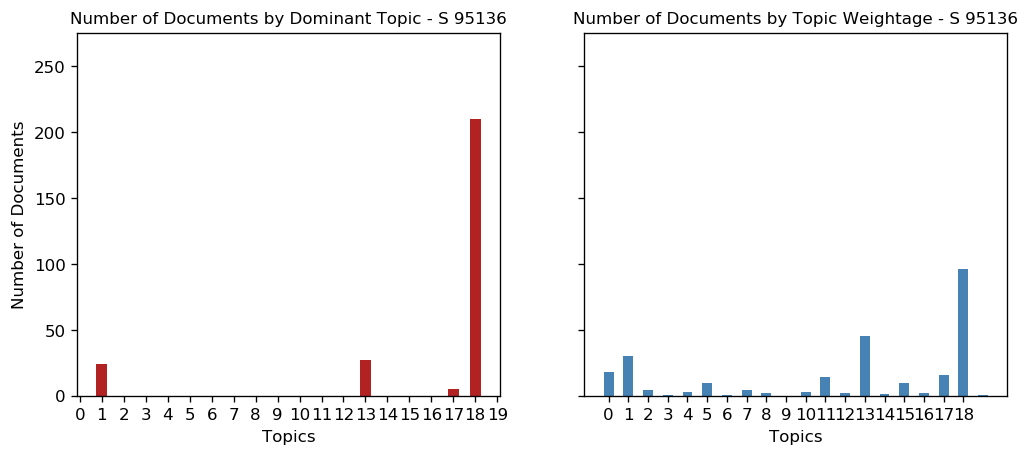

In [212]:
# Plot subject 95136 comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_95, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('Number of Documents by Dominant Topic - S 95136', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 275)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_95, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc_95.index.unique().__len__()))
ax2.set_title('Number of Documents by Topic Weightage - S 95136', fontdict=dict(size=10))
ax2.set_xlabel('Topics') 

plt.show()

In [213]:
df_topic_sents_keywords_95 = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_95136, texts=processed_docs_suicide_95)

# Format
df_dominant_topic_95 = df_topic_sents_keywords_95.reset_index()
df_dominant_topic_95.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_95.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.4546,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
1,1,18.0,0.4546,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
2,2,18.0,0.4546,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
3,3,18.0,0.4078,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
4,4,18.0,0.4078,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
5,5,18.0,0.4078,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
6,6,18.0,0.4037,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
7,7,18.0,0.4037,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
8,8,18.0,0.4036,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
9,9,13.0,0.3853,"pain, histori, nausea, present, patient, deni,...","[patient, test, inform, indic, herceptin, rece..."


In [214]:
#how many document per dominant?
df_dominant_topic_95.groupby('Dominant_Topic').size()

Dominant_Topic
1.0      24
13.0     27
17.0      6
18.0    210
dtype: int64

In [215]:
# subject 523 of suicide attempts
documents_suicide_523 = icd9_suicide.loc[icd9_suicide['SUBJECT_ID'] == 523]

In [216]:
documents_suicide_523 = documents_suicide_523.reset_index()

In [217]:
#use preprocess function on suicide attempt subjects
processed_docs_suicide_523 = documents_suicide_523['text_processed'].map(preprocess)

In [218]:
#create dictionary of words
dictionary_523 = gensim.corpora.Dictionary(processed_docs_suicide_523)

In [219]:
#filter out words that appear in less than (5) documents
#only keep the first 10000
dictionary_523.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

In [220]:
#go through each document and report words and occurrences using doc2box for token id and amount
bow_corpus_523 = [dictionary_523.doc2bow(doc) for doc in processed_docs_suicide_523]

In [221]:
df_topic_sents_keywords_523 = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_523, texts=processed_docs_suicide_523)

# Format
df_dominant_topic_523 = df_topic_sents_keywords_523.reset_index()
df_dominant_topic_523.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_523.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.5300,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
1,1,18.0,0.5143,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
2,2,18.0,0.5279,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
3,3,18.0,0.5279,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
4,4,18.0,0.3139,"tablet, daili, blood, day, sig, discharg, hosp...","[patient, test, inform, indic, hypertens, leav..."
5,5,18.0,0.3131,"tablet, daili, blood, day, sig, discharg, hosp...","[patient, test, inform, indic, hypertens, leav..."
6,6,18.0,0.5576,"tablet, daili, blood, day, sig, discharg, hosp...","[artifact, present, sinu, rhythm, normal, trac..."
7,7,18.0,0.5576,"tablet, daili, blood, day, sig, discharg, hosp...","[artifact, present, sinu, rhythm, normal, trac..."
8,8,18.0,0.7318,"tablet, daili, blood, day, sig, discharg, hosp...","[sinu, arrhythmia, tall, peak, wave, rightward..."
9,9,18.0,0.7319,"tablet, daili, blood, day, sig, discharg, hosp...","[sinu, arrhythmia, tall, peak, wave, rightward..."


In [222]:
#sorted and appending topics and percentages of the LDA topics
dominant_topics_523, topic_percentages_523 = topics_per_document(lda_model, bow_corpus_523)            

# Distribution of Dominant Topics in Each Document
df_523 = pd.DataFrame(dominant_topics_523, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_523 = df_523.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_523 = dominant_topic_in_each_doc_523.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_523 = pd.DataFrame([dict(t) for t in topic_percentages_523])
df_topic_weightage_by_doc_523 = topic_weightage_by_doc_523.sum().to_frame(name='count').reset_index()

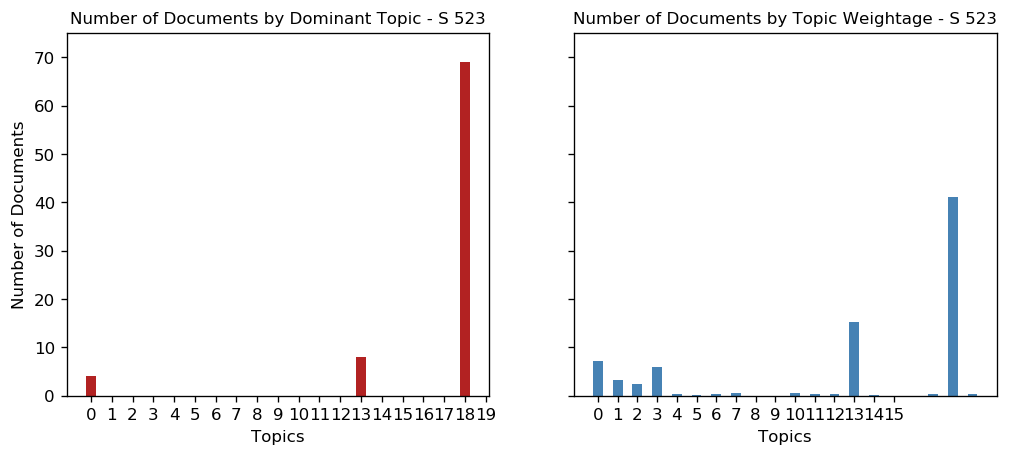

In [223]:
# Plot for subject 523 comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_523, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('Number of Documents by Dominant Topic - S 523', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 75)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_523, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc_523.index.unique().__len__()))
ax2.set_title('Number of Documents by Topic Weightage - S 523', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

Results so far:
All three suicide attempt subjects ranked Topic 18 as their most dominant topic for all of their documents 
Additionally, each subject only had 3 or 4 dominant topics (probability highest among all potential)
Whereas, the DoD subject has almost all 20 dominant topics for their documents (which makes sense because they are from the training data)
DoD subject also ranked Topic 18 as having the most documents under this topic.
Is Topic 18 the best identifier of high risk patients?

In [225]:
#use preprocess function on entire documents for suicide attempt
s_proc_docs = icd9_suicide['text_processed'].map(preprocess)

In [226]:
#create dictionary of words and number of appearances 
s_dictionary = gensim.corpora.Dictionary(s_proc_docs)

In [227]:
#filter out words that appear in less than (15) documents
#only keep the first 10000
s_dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [228]:
#go through each document and report words and occurrences using doc2box for token id and amount
s_bow_corpus = [s_dictionary.doc2bow(doc) for doc in s_proc_docs]

In [261]:
#determine the TF-IDF scores or weight of a word within a document
from gensim import corpora, models
s_tfidf = models.TfidfModel(s_bow_corpus)
s_corpus_tfidf = s_tfidf[s_bow_corpus]

In [229]:
#sorted and appending topics and percentages of the LDA topics (function can be found above)
dominant_topics_s, topic_percentages_s = topics_per_document(lda_model, s_bow_corpus)            

# Distribution of Dominant Topics in Each Document
df_s = pd.DataFrame(dominant_topics_s, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_s = df_s.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_s = dominant_topic_in_each_doc_s.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_s = pd.DataFrame([dict(t) for t in topic_percentages_s])
df_topic_weightage_by_doc_s = topic_weightage_by_doc_s.sum().to_frame(name='count').reset_index()

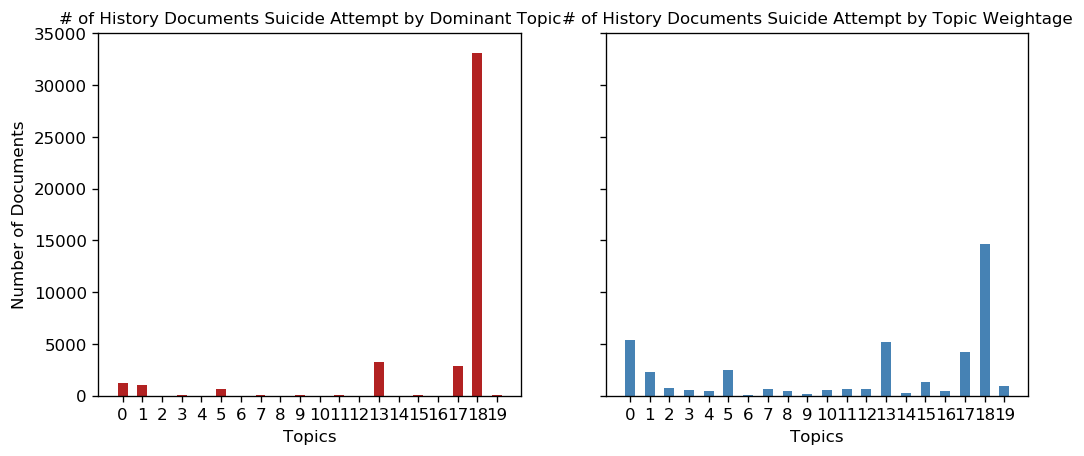

In [230]:
# Plot for comparing document topics from suicide attempts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_s, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('# of History Documents Suicide Attempt by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 35000)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_s, width=.5, color='steelblue')
ax2.set_xticks(range(0,20))
ax2.set_title('# of History Documents Suicide Attempt by Topic Weightage', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

In [231]:
df_topic_sents_keywords_s = format_topics_sentences(ldamodel=lda_model, corpus=s_bow_corpus, texts=s_proc_docs)

# Format
df_dominant_topic_s = df_topic_sents_keywords_s.reset_index()
df_dominant_topic_s.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [232]:
#what is the min and max probability for matching a topic?
df_dominant_topic_s['Topic_Perc_Contrib'].describe()

count    42553.000000
mean         0.414293
std          0.129890
min          0.050000
25%          0.319500
50%          0.391200
75%          0.492000
max          0.932000
Name: Topic_Perc_Contrib, dtype: float64

In [233]:
df_dominant_topic_s.groupby('Dominant_Topic').size()

Dominant_Topic
0.0      1223
1.0      1007
2.0        12
3.0        62
4.0         8
5.0       692
7.0        40
8.0         2
9.0        28
10.0        9
11.0       32
12.0       14
13.0     3215
14.0        8
15.0       82
16.0        1
17.0     2906
18.0    33133
19.0       79
dtype: int64

Overall Suicide attempt documents as a whole:
Document 18 is the dominant topic. 
The average probability for a document belonging to a topic is 0.42, with a max of 0.93

In [262]:
#sorted and appending topics and percentages of the LDA topics tf-idf
dominant_topics_stf, topic_percentages_stf = topics_per_document(lda_model2, s_corpus_tfidf)            

# Distribution of Dominant Topics in Each Document
df_stf = pd.DataFrame(dominant_topics_stf, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_stf = df_stf.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_stf = dominant_topic_in_each_doc_stf.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_stf = pd.DataFrame([dict(t) for t in topic_percentages_stf])
df_topic_weightage_by_doc_stf = topic_weightage_by_doc_stf.sum().to_frame(name='count').reset_index()

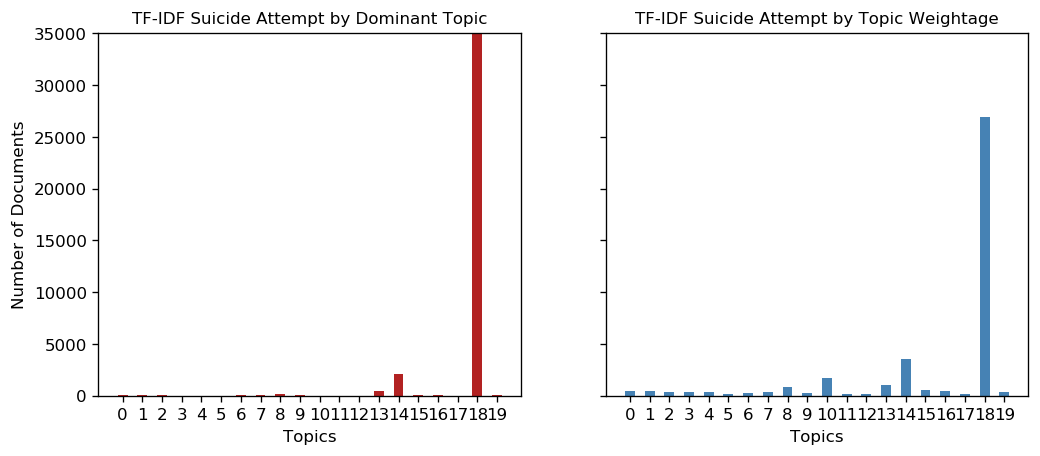

In [264]:
# Plot for comparing document topics from suicide attempts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_stf, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('TF-IDF Suicide Attempt by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 35000)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_stf, width=.5, color='steelblue')
ax2.set_xticks(range(0,20))
ax2.set_title('TF-IDF Suicide Attempt by Topic Weightage', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

In [265]:
df_topic_sents_keywords_stf = format_topics_sentences(ldamodel=lda_model2, corpus=s_corpus_tfidf, texts=s_proc_docs)

# Format
df_dominant_topic_stf = df_topic_sents_keywords_stf.reset_index()
df_dominant_topic_stf.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [269]:
df_dominant_topic_stf.groupby('Dominant_Topic').size()

Dominant_Topic
0.0        40
1.0        23
2.0        55
3.0         2
4.0         2
5.0         7
6.0        24
7.0        73
8.0       177
9.0        21
10.0       16
11.0        1
12.0       16
13.0      500
14.0     2070
15.0       57
16.0       29
17.0        4
18.0    39393
19.0       43
dtype: int64

In [274]:
df_topic_weightage_by_doc_stf

,index,count
0,0,455.976156
1,1,437.331655
2,2,355.814969
3,3,328.933950
4,4,374.795007
5,5,150.401305
6,6,301.083201
7,7,363.363467
8,8,880.971059
9,9,217.159056


In [ ]:
42553.  590

In [ ]:
##lets look at 1 or 2 diabetes patients and see how many dominant topics and weightage ranks up 

In [235]:
#filter for only diabetes ICD9 codes
diag_db_DF = diagnosis_icd9[diagnosis_icd9["ICD9_CODE"].str.startswith(('250', '249', '648', 'E08', 'E09', 'E10', 'E11', 'E13'), na = False)]
diag_db_DF.head()

,SUBJECT_ID,ICD9_CODE
71,117,25000
91,117,25000
113,123,25000
206,130,25000
214,130,25060


In [236]:
#merge diabetes dataframe with notes
icd9_db_notes = pd.merge(diag_db_DF, notes, on ='SUBJECT_ID')
icd9_db_notes

,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT
0,117,25000,Discharge summary,Admission Date: [**2133-4-7**] Discharge ...
1,117,25000,Discharge summary,Admission Date: [**2133-11-13**] ...
2,117,25000,Echo,PATIENT/TEST INFORMATION:\nIndication: Murmur....
3,117,25000,Echo,PATIENT/TEST INFORMATION:\nIndication: Left ve...
4,117,25000,ECG,Atrial fibrillation with uncontrolled ventricu...
...,...,...,...,...
1587475,97488,25000,Radiology,[**2128-8-31**] 1:25 PM\n CHEST PORT. LINE PLA...
1587476,97488,25000,Radiology,[**2128-9-2**] 4:01 AM\n CHEST (PORTABLE AP) ...
1587477,97488,25000,Radiology,[**2128-9-4**] 5:36 AM\n CHEST (PORTABLE AP) ...
1587478,97488,25000,Radiology,[**2128-9-3**] 3:23 AM\n CHEST (PORTABLE AP) ...


In [237]:
#select only for discharge summary
icd9_db_notes = icd9_db_notes.loc[icd9_db_notes['CATEGORY'] == 'Discharge summary']

In [238]:
icd9_db_notes = icd9_db_notes.drop_duplicates(subset='TEXT', keep='first')

In [241]:
d_documents = icd9_db_notes.reset_index()

In [240]:
# Remove punctuation and anything that isnt a character or number 
icd9_db_notes['text_processed'] = icd9_db_notes['TEXT'].map(lambda x: re.sub('[_\\W]+', ' ', x))
#remove numbers
icd9_db_notes['text_processed'] = icd9_db_notes['text_processed'].map(lambda x: re.sub('(\\s\\d+)', ' ', x))
# Convert to lowercase
icd9_db_notes['text_processed'] = icd9_db_notes['text_processed'].map(lambda x: x.lower())

In [242]:
d_documents

,index,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT,text_processed
0,0,117,25000,Discharge summary,Admission Date: [**2133-4-7**] Discharge ...,admission date discharge date date of bi...
1,1,117,25000,Discharge summary,Admission Date: [**2133-11-13**] ...,admission date discharge date date of bi...
2,212,123,25000,Discharge summary,Admission Date: [**2161-10-29**] Discharg...,admission date discharge date date of bi...
3,232,130,25000,Discharge summary,Unit No: [**Numeric Identifier 56787**]\nAdmi...,unit no numeric identifier admission date ...
4,233,130,25000,Discharge summary,Unit No: [**Numeric Identifier 56787**]\nAdmi...,unit no numeric identifier admission date ...
...,...,...,...,...,...,...
17379,1587064,96908,25060,Discharge summary,Admission Date: [**2145-2-2**] D...,admission date discharge date date of bi...
17380,1587065,96908,25060,Discharge summary,Admission Date: [**2145-9-4**] D...,admission date discharge date date of bi...
17381,1587379,97144,25000,Discharge summary,Admission Date: [**2187-2-7**] D...,admission date discharge date service ca...
17382,1587420,97488,25062,Discharge summary,Admission Date: [**2128-4-8**] D...,admission date discharge date date of bi...


In [243]:
#use preprocess function 
d_proc_docs = d_documents['text_processed'].map(preprocess)

In [255]:
d_proc_docs

0        [admiss, date, discharg, date, date, birth, se...
1        [admiss, date, discharg, date, date, birth, se...
2        [admiss, date, discharg, date, date, birth, se...
3        [unit, numer, identifi, admiss, date, discharg...
4        [unit, numer, identifi, admiss, date, discharg...
                               ...                        
17379    [admiss, date, discharg, date, date, birth, se...
17380    [admiss, date, discharg, date, date, birth, se...
17381    [admiss, date, discharg, date, servic, cardiot...
17382    [admiss, date, discharg, date, date, birth, se...
17383    [admiss, date, discharg, date, date, birth, se...
Name: text_processed, Length: 17384, dtype: object

In [244]:
#create dictionary of words and number of appearances 
d_dictionary = gensim.corpora.Dictionary(d_proc_docs)

In [245]:
#filter out words that appear in less than (15) documents
#only keep the first 10000
d_dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [246]:
#go through each document and report words and occurrences using doc2box for token id and amount
d_bow_corpus = [d_dictionary.doc2bow(doc) for doc in d_proc_docs]

In [267]:
#determine the TF-IDF scores or weight of a word within a document
from gensim import corpora, models
d_tfidf = models.TfidfModel(d_bow_corpus)
d_corpus_tfidf = d_tfidf[d_bow_corpus]

In [247]:
#using previous function to run with lda model
df_topic_sents_keywords_d = format_topics_sentences(ldamodel=lda_model, corpus=d_bow_corpus, texts=d_proc_docs)

# Format
df_dominant_topic_d = df_topic_sents_keywords_d.reset_index()
df_dominant_topic_d.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_d['Document_No'] = np.arange(1, len(df_dominant_topic_d) + 1)
df_dominant_topic_d.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,1,18.0,0.5191,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
1,2,18.0,0.5953,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
2,3,18.0,0.4444,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
3,4,18.0,0.4273,"tablet, daili, blood, day, sig, discharg, hosp...","[unit, numer, identifi, admiss, date, discharg..."
4,5,18.0,0.4650,"tablet, daili, blood, day, sig, discharg, hosp...","[unit, numer, identifi, admiss, date, discharg..."
5,6,13.0,0.3369,"pain, histori, nausea, present, patient, deni,...","[admiss, date, discharg, date, date, birth, se..."
6,7,18.0,0.4339,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
7,8,18.0,0.3738,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
8,9,18.0,0.2937,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
9,10,18.0,0.2823,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."


In [248]:
#sorted and appending topics and percentages of the LDA topics for diabetes 
dominant_topics_d, topic_percentages_d = topics_per_document(lda_model, d_bow_corpus)            

# Distribution of Dominant Topics in Each Document
df_d = pd.DataFrame(dominant_topics_d, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_d = df_d.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_d = dominant_topic_in_each_doc_d.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_d = pd.DataFrame([dict(t) for t in topic_percentages_d])
df_topic_weightage_by_doc_d = topic_weightage_by_doc_d.sum().to_frame(name='count').reset_index()

In [249]:
df_dominant_topic_d.groupby('Dominant_Topic').size()

Dominant_Topic
0.0       141
1.0        13
2.0         4
3.0         9
5.0       109
7.0         2
8.0         1
10.0        1
12.0        3
13.0      408
14.0       21
15.0        8
16.0        2
17.0       88
18.0    16574
dtype: int64

In [250]:
#what is the min and max probability for matching a topic?
df_dominant_topic_d['Topic_Perc_Contrib'].describe()

count    17384.000000
mean         0.322340
std          0.071847
min          0.145300
25%          0.275500
50%          0.312800
75%          0.356300
max          0.887600
Name: Topic_Perc_Contrib, dtype: float64

In [277]:
df_topic_weightage_by_doc_dtf

,index,count
0,13,166.771331
1,18,10816.451431
2,10,1318.264935
3,3,75.616242
4,6,78.377377
5,4,50.931785
6,14,2033.278331
7,15,219.358541
8,0,167.793926
9,1,52.995170


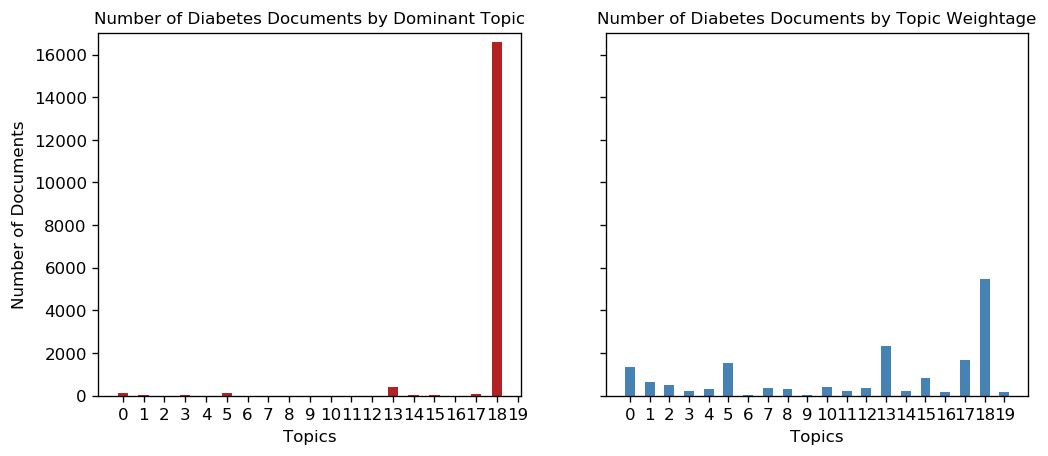

In [276]:
#topic weightage is the sum of all documents that have a weight for that topic

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_d, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('Number of Diabetes Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 17000)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_d, width=.5, color='steelblue')
ax2.set_xticks(range(0,20))
ax2.set_title('Number of Diabetes Documents by Topic Weightage', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

In [268]:
#using previous function to run with lda model2 tf-idf
df_topic_sents_keywords_dtf = format_topics_sentences(ldamodel=lda_model2, corpus=d_corpus_tfidf, texts=d_proc_docs)

# Format
df_dominant_topic_dtf = df_topic_sents_keywords_dtf.reset_index()
df_dominant_topic_dtf.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_dtf['Document_No'] = np.arange(1, len(df_dominant_topic_dtf) + 1)
df_dominant_topic_dtf.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,1,18.0,0.8087,"tablet, daili, patient, day, sig, discharg, bl...","[admiss, date, discharg, date, date, birth, se..."
1,2,18.0,0.9062,"tablet, daili, patient, day, sig, discharg, bl...","[admiss, date, discharg, date, date, birth, se..."
2,3,18.0,0.8774,"tablet, daili, patient, day, sig, discharg, bl...","[admiss, date, discharg, date, date, birth, se..."
3,4,18.0,0.8693,"tablet, daili, patient, day, sig, discharg, bl...","[unit, numer, identifi, admiss, date, discharg..."
4,5,18.0,0.8749,"tablet, daili, patient, day, sig, discharg, bl...","[unit, numer, identifi, admiss, date, discharg..."
5,6,18.0,0.9099,"tablet, daili, patient, day, sig, discharg, bl...","[admiss, date, discharg, date, date, birth, se..."
6,7,18.0,0.8608,"tablet, daili, patient, day, sig, discharg, bl...","[admiss, date, discharg, date, date, birth, se..."
7,8,18.0,0.7797,"tablet, daili, patient, day, sig, discharg, bl...","[admiss, date, discharg, date, date, birth, se..."
8,9,18.0,0.7520,"tablet, daili, patient, day, sig, discharg, bl...","[admiss, date, discharg, date, date, birth, se..."
9,10,18.0,0.7544,"tablet, daili, patient, day, sig, discharg, bl...","[admiss, date, discharg, date, date, birth, se..."


In [270]:
df_dominant_topic_dtf.groupby('Dominant_Topic').size()

Dominant_Topic
0.0         5
1.0         1
2.0         1
3.0         1
8.0         6
9.0         1
10.0        1
13.0       15
14.0       99
15.0        3
16.0        5
18.0    17246
dtype: int64

In [272]:
#sorted and appending topics and percentages of the LDA topics for diabetes 
dominant_topics_dtf, topic_percentages_dtf = topics_per_document(lda_model2, d_corpus_tfidf)            

# Distribution of Dominant Topics in Each Document
df_dtf = pd.DataFrame(dominant_topics_dtf, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_dtf = df_dtf.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_dtf = dominant_topic_in_each_doc_dtf.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_dtf = pd.DataFrame([dict(t) for t in topic_percentages_dtf])
df_topic_weightage_by_doc_dtf = topic_weightage_by_doc_dtf.sum().to_frame(name='count').reset_index()

In [ ]:
#topic weightage is the sum of all documents that have a weight for that topic

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_d, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('Number of Diabetes Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_d, width=.5, color='steelblue')
ax2.set_xticks(range(0,20))
ax2.set_title('Number of Diabetes Documents by Topic Weightage', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

Overall: Ive been able to preprocess my text using basic RE expressions, and then lemmatize and stem to get a more uniform text.
This text is then used to train my LDA model using either BOW or TF-IDF. Visualization of these results as then implemented to understand the topics produced by the LDA model and how outside documents fall under those topics. 

Results so far:
Document 18 is the dominant topic for both the diabetes and suicide attempt groups.
Document 18's top weighted words include: (18,
  '0.028*"tablet" + 0.019*"daili" + 0.017*"blood" + 0.017*"day" + 0.016*"sig" '
  '+ 0.015*"discharg" + 0.012*"hospit" + 0.009*"patient" + 0.008*"histori" + '
  '0.008*"medic"') - it appears that this topic is talking about routine and when to take medications. Sig is an abbreviation for prescriptions to describe when to take a medication i.e TID 3x a day
  
Diabetes group has a max of 89% and min of 15%, with an average probability of matching the LDA topics as 32%. This group has at least 1 document falling under 15/20 topics. Out of these 15 topics, 18 and 13 are highest, with the rest containing <10 documents. Document 13 talks about pain, nausea, vomiting, denial, medications etc. These could be symptoms of a certain diagnosis, or state.

Suicide Attempt group has a max of 93% and min of 5%, with and average probability of matching the LDA topics as 41%. Because there is a document with a probability of only matching a Topic by 5%, it should be considered that a threshold is instated.
This group also has at least 1 document falling under 19/20 topics. Out of these 19 topics, 18, 13, 17, 0 and 1 have the greatest amount of documents falling under those documents. Topic 18 and 13 were already described above. Topic 17 describes status, seizures, mental, families, transfer etc. This topic could be referring to present state of a subject, most likely having seizures, or mental disorder, potentially there has been many transfers from previous medical institutions/visits. Topic 0 describes blood/blood work. Lastly, Topic 1 describes respiratory and heart conditions like COPD and needing diuretic medication. Topic 17 and 1 coule have some valuable information regarding the subjects.

Perhaps the next step is that we could apply a T-Test to determine if diabetes and suicide probabilities are significantly different 

Results for TF-IDF LDA Model: The TF-IDF model seems to give us topics that have more meaningful insight and less generalalized.

Suicide attempt group dominant topics are in order, topic 18, topic 14, 13, and 8. Now dont be confused with the first topics discussed. This was a completly different LDA model. Topic 18 is: (18,'0.006*"tablet" + 0.005*"daili" + 0.005*"patient" + 0.004*"day" + ''0.004*"sig" + 0.004*"discharg" + 0.004*"blood" + 0.003*"pain" + 0.003*"neg" ''+ 0.003*"unit"') - which is actually almost entirely the same as the LDA model that was ran using BOW. This verifies that are LDA is running the same consistantly. Additionally this doesnt give us any meaningful insight in the group. Topic 14 has words like action, response, assess, plan, continue as is a topic about continuing regimen and is not meaningful in identifying high risk patients. Topic 13 top words describe icu, code, cmh (Cardiomyopathy, Hypertrophic; Community Mental Health [services Or Program]; Congenital Malformation Of The Heart.) spo (Saturation of Peripheral Oxygen) and pulse. This topic could be about the heart. Topic 8: contrast, pelvis, abdomen, liver, gallbladder is a topic about the stomach and potential complications with the organs nearby.

The diabetes group had almost all documents fall under Topic 18, with a few under 14 and 13. All described above and generally all of these topics are describing day to day routine with the patients. 

With that being said, Topics like 18, 14 and 13 should be excluded from the analysis and look at topics that have the next highest probability (weight) of matching, giving meaningful insight into the patients and potentially concepts that could identify subjects at high risk. So instead of looking at the dominant topics found among groups, we can analyze the topics based on topics with the highest cummulative weight. Meaning that one document might have a probability of falling under 3 topics, each with an individual probability. i.e doc. 3 has probabilities 0.45 for topic 1, 0.44 for topic 2 and 0.3 for topic 3, Topic 1 is deemed the 'dominant topic' and topic 2 and 3 are forgotten about. If we used the probabilities regardless, topic 2 even though its almost the same probability as topic 1, is still taken into consideration. Those probabilities per topic are then summed and analyzed.

Using summed probabilities per Topic: Topic 10 '0.015*"ciwa" + 0.012*"swallow" + 0.011*"pod" + 0.010*"bal" + 0.008*"smx" + ''0.008*"tmp" + 0.008*"hypercarb" + 0.007*"valium" + 0.007*"tracheomalacia" + ''0.007*"viru"' is highest and seems to be describing CIWA or Clinical Institute Withdrawal Assessment for Alcohol, tmp/smx is Trimethoprim/sulfamethoxazole used for treating bacterial infections, tracheomalacia is the collapsing of the trachea, hypercarbia is too much CO2 levels due to not being able to breathe properly. 
Topic 15 the next highest cummulative probability describes fractures, spine, hip, cervical, joint, trauma. The rest of the topics have similar sum, but its to be noted that the average sums for the suicide attempt group is significantly larger than that of the diabetes group.